# <center>SageMath implementation of the _GGH_ signature scheme [GGH97]<br>and the _Learning a Parallelepiped_ attack [NR06]</center>

# Helper functions

## Babai nearest plane algorithm

(_Babai, László. "On Lovász’ lattice reduction and the nearest lattice point problem." Combinatorica 6.1 (1986): 1-13._)
$$ $$

The **Babai nearest plane algorithm** computes an approximation of the *Closest Vector Problem (CVP)*. 

This algorithm is able to achieve an approximation ratio of $2^\frac{n}{2}$, where $n$ is the rank of the lattice.

In [1]:
def babai(B, Bgs, w):
    '''
    based on: https://cims.nyu.edu/~regev/teaching/lattices_fall_2004/ln/cvp.pdf
    '''
    v = w
    for i in range(B.nrows()-1, -1, -1):
        ci = round((v * Bgs[i]) / (Bgs[i] * Bgs[i]))
        v -= ci * B[i]
    return w - v

## Hadamard ratio / Orthogonality defect

(_Hoffstein, Jeffrey, et al. An introduction to mathematical cryptography. Vol. 1. P. 397. New York: Springer, 2008._)
$$ $$

In order to **quantify the orthogonality of a basis**, the **Hadamard ratio**, or the **orthogonality defect** (for its reciprocal), may be used. It represents the ratio between the determinant of the lattice (_volume_ of the parallelepiped) and the product of the basis vectors. 

This ratio takes values in the $(0,1]$ interval, with $1$ when all the vectors of the basis are orthogonal to one another.

Another possibility would be to use the ratio between the lengths of the basis vectors of the Gram-Schmidt orthogonalization, as vectors with very different lengths describe a highly non-orthogonal (original) basis.

In [2]:
def hadamard_ratio(A):
    '''
    [0,1] -> 1 orthogonal
    can also use gram-schmidt ratio:
    GSratio(A):
        normGS = map(norm, A.gram_schmidt()[0])
        return normGS[0] / min(normGS)
    '''
    return ( sqrt((A.T*A).determinant()) / mul(map(norm, A)) )^(1/A.nrows())

# GGH signature scheme

(_Goldreich, Oded, Shafi Goldwasser, and Shai Halevi. "Public-key cryptosystems from lattice reduction problems." Annual International Cryptology Conference. Springer, Berlin, Heidelberg, 1997._)

(_Micciancio, Daniele. "Improving lattice based cryptosystems using the Hermite normal form." Cryptography and lattices. Springer, Berlin, Heidelberg, 2001. 126-145._)
$$ $$

This lattice signature scheme uses a *good* lattice basis as the secret key and a *bad* basis of the lattice as the public key. On one hand, the signature is simply a vector of the lattice *close enough* to the message, which can easily be computed with a *good* basis, but it is hard to find with a *bad* basis. On the other hand, to verify such signature, it is enough to check that it is a lattice vector and that its distance to the message is below some given threshold. The messages are assumed to be previously hashed into a set much larger than the fundamental domain of the lattice.

Originally presented by **Goldreich, Goldwasser, and Halevi** (1997), was improved by **Micciancio** (2001). Although they are both quite similar, here, the improved second version was implemented.


## Implementation 
#### input:

1. $n$: dimension of the lattice
2. $l$: entires of the secret key basis in $[-l,l]$
3. $sk\_orth\_min$: minimum value for the Hadamard ratio of the secret key

#### keygen:

- **secret key** basis $\mathbf{R}$ generated by taking the LLL reduction of a matrix with integer values in $[-l, l]$ and given Hadamard ratio
- **public key** basis $\mathbf{B}$ is the Hermite Normal Form (HNF) of the secret basis $\mathbf{B} = HNF(\mathbf{R})$

#### setkeys:

- sets given keys as the keypair

#### sign:

- signs a given message with the secret key using Babai's algorithm

#### verify:

- verifies the signature with the public key. i.e. checks if the signature is a lattice vector and that it is *close enough* (given a threshold value) to the message

In [3]:
import sage.matrix.matrix_integer_dense_hnf as matrix_integer_dense_hnf

class GGH:
    def __init__(self, n, l, sk_orth_min):
        self.keygen(n, l, sk_orth_min)
        
    def setkeys(self, sk, pk):
        self.sk = sk
        self.pk = pk
        
    def keygen(self, n, l, sk_orth_min, max_it=10^4):
        # compute secret key:
        i = 0
        while True: # find sk with hadamard_ration > sk_orth_min
            R = random_matrix(ZZ, n, x = -l, y = l)
            if hadamard_ratio(R) > sk_orth_min:
                break
            i += 1
            if i > max_it:
                raise Exception('KEYGEN: max it reached for finding sk.')
        self.sk = R.LLL()
        self.skGS = self.sk.gram_schmidt()[0]
        # compute public key:
        B = matrix_integer_dense_hnf.hnf(self.sk)[0]
        self.pk = B

    def sign(self, m):
        return babai(self.sk, self.skGS, m)
    
    def verify(self, s, m, tau):
        # L(B) = {Bx: x \in ZZ} => B^(-1)s = x \in ZZ
        s_in_latticeQ = all(map(lambda x: x in ZZ, s * self.pk.inverse()))
        # debug:
        print "VERIFY: sig in lattice:", s_in_latticeQ
        print "VERIFY: ||sig - mess|| <= tau:", norm(m - s).n(), "<=", N(tau)
        # end debug
        if s_in_latticeQ and norm(m - s) <= tau: 
            return "VALID"
        return "invalid"

## Example

In [4]:
def example():
    n = 100
    l = n
    sk_orth_min = 0.5

    ggh = GGH(n, l, sk_orth_min)
    
    m  = random_vector(ZZ, n, x=-10^3, y=10^3)
    s = ggh.sign(m)
    tau = ggh.sk.norm(1)*sqrt(n)/2
    print ggh.verify(s, m, tau)
    
example()

VERIFY: sig in lattice: True
VERIFY: ||sig - mess|| <= tau: 1033.31892463073 <= 33415.0000000000
VALID


# The attack
(_Nguyen, Phong Q., and Oded Regev. "Learning a parallelepiped: Cryptanalysis of GGH and NTRU signatures." Annual International Conference on the Theory and Applications of Cryptographic Techniques. Springer, Berlin, Heidelberg, 2006._)
$$ $$

Nguyen and Regev presented in 2006 an attack in which, given a set of message-signature pairs and the public basis, allowed to recover the secret key. They presented this in the context of a cryptanalysis of both the **GGH** and the **NTRU** signature schemes. Here, and in the rest of this work, the attack to the **GGH** signature is presented.

The attack basically consists in solving the _Hidden Parallelepiped Problem_. In fact, it had already been noticed that each signature $\mathbf{s}$ leaks information about the secret key. This allows an attacker to identify the shape of the fundamental parallelepiped generated by the secret key, as the signature generation reduces the message $\mathbf{m}$ modulo the parallelepiped spanned by the secret basis.

## The Hidden Parallelepiped Problem (HPP)
Given a set of random vectors uniformly distributed over an $n$-dimensional parallelepiped, recover the parallelepiped. In order to solve this problem,  Nguyen and Regev transform it into a multivariate optimization problem, which can be solved using gradient descent methods.

First, it is assumed that the distribution of the vectors $\mathbf{s} - \mathbf{m}$ is close to uniform in the secret parallelepiped, and moreover, that they are independent from one another. Note that here the distribution is discrete, and the attack uses the fact that the volume of the lattice is large enough.

#### Definition (HPP): 
Let $\mathbf{V} = [\mathbf{v}_1,\dots,\mathbf{v}_n] \in GL_n(\mathbb{R})$ and let $\mathcal{P}(\mathbf{V}) = \{\sum_{i=1}^n x_i\mathbf{v}_i : x_i \in [-1,1]\}$ be the parallelepiped spanned by $\mathbf{V}$. The input to the HPP is a sequence of $\text{poly}(n)$ independent samples from $U(\mathcal{P}(\mathbf{V}))$ (uniform distribution). The goal is to find a good approximation of the rows of $\pm\mathbf{V}$.

Solving the HPP problem will find an approximation to a vector of the secret basis of a GGH instance, not necessarily a lattice vector. Then, to obtain the actual secret basis vectors from these approximations, one may simply round the coordinates of the approximation to the closest integer. Here, approximate-CVP algorithms (namely Babai's CVP algorithm) are used to recover the secret basis given another lattice basis (in this case the public key).


## Learning the parallelepiped
#### input:
A polynomial number of samples of message-signature pairs.

#### output:
Approximation of rows of $\pm\mathbf{V}$.

1. Leak the covariance matrix.

2. Map the problem to an **hypercube**, reducing solving HPP to solving Hidden Hypercube Problem (HHP), where an hypercube (spanned by $\mathbf{C}$) is learned instead of a parallelepiped (spanned by $\mathbf{V}$).

3. Use gradient descent to compute an approximation of the rows of $\pm\mathbf{C}$.

4. Invert the transformation to get the solution to the HPP. Then compute  the closest lattice vector (using Babai's algorithm with the LLL-reduced public key) to obtain the secret key vector.

### Generate $n$ samples
These are the message-signature pairs that are available to the attacker, together with the public key.

In [5]:
n = 2            # dimension of the lattice
l = 100 #n       # magnitude of private basis, usually l=n
n_samples = 1000 # number of samples

ggh = GGH(n, l, sk_orth_min=0.5)

samples = []
for i in range(n_samples):
    #if i % 100 == 0: print i
    m = random_vector(ZZ, n, x=-10^3, y=10^3) 
    s = ggh.sign(m) # sign random message
    samples.append(2*(s - m)) # map to paralellepiped
samples = matrix(samples)

### Leak the covariance matrix (1)
Leak the covariance matrix by computing an approximation $\mathbf{G}$ of the Gram matrix $\mathbf{V}^t\mathbf{V}$ of $\mathbf{V}^t$. In fact, the covariance matrix of the distribution $U(\mathcal{P}(\mathbf{V}))$ is $\mathbf{V}^t\mathbf{V}/3$.

In [6]:
G = (3/n_samples) * (samples.transpose() * samples)

### Transform HPP into HHP (2)
Compute the Cholesky factor $\mathbf{L}$ of $\mathbf{G}^{-1}$, so that $\mathbf{G}^{-1} = \mathbf{L}\mathbf{L}^t$. Note the Cholesky factorization can be computed in polynomial time.

Map the problem to an hypercube by multiplying the samples of $\mathcal{P}(\mathbf{V})$ by $\mathbf{L}$ to the right to obtain samples of $\mathcal{P}(\mathbf{C})$ where $\mathbf{C} = \mathbf{V}\mathbf{L}$. This reduces solving HPP to solving a Hidden Hypercube Problem (HHP) where an hypercube is learned instead of a parallelepiped. Indeed, the rows of $\mathbf{C}$ are pairwise orthogonal unit vectors, and if $\mathbf{v}$ is uniformly distributed over $\mathcal{P}(\mathbf{V})$, then $\mathbf{c} = \mathbf{v}\mathbf{L}$ is uniformly distributed over the hypercube $\mathcal{P}(\mathbf{C})$.

In [7]:
L = G.inverse().cholesky().n() # \in AA. need to convert to finite precision ( .n() ) or later it'll take forever...
samples_hypercube = samples * L

### Learn the hypercube (3)
Given the samples in the hypercube, the HHP problem is solved by a multivariate optimization problem on the fourth moment of the distribution, i.e. the kurtosis, by using gradient descent. There will be no local minima other than the global minimum of this quantity over the unit sphere of $\mathbb{R}^n$, which is $1/5$ and is obtained at $\pm\mathbf{v}_1,\dots,\pm\mathbf{v}_n$.

Therefore, the problem is solved by using gradient descent to minimize the kurtosis, given the parameter $\delta$, for which $0.7$ is suggested.

Finally, given the samples of the distribution, the kurtosis over a vector $\mathbf{w} \in \mathbb{R}^n$ is estimated as
$$ \text{mom}_{\mathbf{V},4}(\mathbf{w}) = \text{Exp}[\left< \mathbf{u}, \mathbf{w} \right>^4]$$

while the gradient is computed as 
$$ \nabla \text{mom}_{\mathbf{V},4}(\mathbf{w}) = \text{Exp}[\nabla \left< \mathbf{u}, \mathbf{w} \right>^4] = 4\ \text{Exp}[\left< \mathbf{u}, \mathbf{w} \right>^3 \mathbf{u}]$$

thus both can be computed by averaging over the given samples.

In [8]:
class grad_desc:
    def __init__(self, delta, n, ss):
        assert ss.ncols() == n
        self.n = n
        self.delta = delta
        self.samples = ss
        self.nsamples = ss.nrows()
        
    def mom4(self, w): # estimate the kurtosis
        return (1/self.nsamples) * sum([x^4 for x in (self.samples*w)])

    def grad_mom4(self, w): # estimate the gradient of the kurtosis
        return (4/self.nsamples) * \
            sum([dot^(3)*vi for (dot,vi) in zip((self.samples*w), self.samples)])
        
    def run(self): # do the gradient descent
        slow = self.delta * 10^-3
        # 1: pick w0 at random from unit sphere in RR^n
        w_new = random_vector(RR, self.n)
        w_new /= norm(w_new)
        while 1:
            w = w_new
            # 2: grad mom_4(w) from empirical distribution
            g = self.grad_mom4(w)
            # 3. descent
            w_new = w - self.delta * g
            # 4. normalize w_new
            w_new /= norm(w_new)
            # 5. check and return
            m4new = self.mom4(w_new)
            m4 = self.mom4(w)
            if m4 - m4new < slow:
                return w
        
    def run_n(self, n): # do n gradient descents, pick the min
        r = self.run()
        i = 0
        for i in range(n - 1):
            temp = self.run()
            if self.mom4(temp) < self.mom4(r): 
                r = temp
        print 'found vector: ', r
        print 'with kurtosis:', self.mom4(r)
        return r

In [9]:
gd = grad_desc(0.7, n, samples_hypercube)
w = gd.run_n(3)

found vector:  (-0.907096945712845, -0.420921763607476)
with kurtosis: 0.203676494674995


### Map back to the parallelepiped (4)
Finally, with an approximations of the rows of $\mathbf{C}$ it is possible to get an approximation of the rows of $\mathbf{V}$ by applying the inverse transformation $\mathbf{L}^{-1}$.

In [10]:
v = vector(map(round, w*L.inverse()))
pklll = ggh.pk.LLL(delta=0.99)
sol = babai(pklll, pklll.gram_schmidt()[0], v)
cheat = babai(ggh.sk, ggh.skGS, v)
print "found vector     :", v
print "babai with pk.LLL:", sol
print "babai with sk:    ", cheat
print "leaked sk vector?:", (sol in list(ggh.sk)) or ((-1*sol) in list(ggh.sk))

found vector     : (-23, -26)
babai with pk.LLL: (-17, -30)
babai with sk:     (-17, -30)
leaked sk vector?: True


# Plots

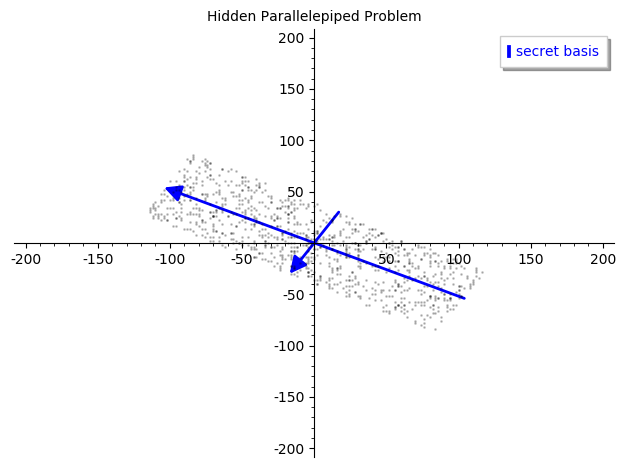

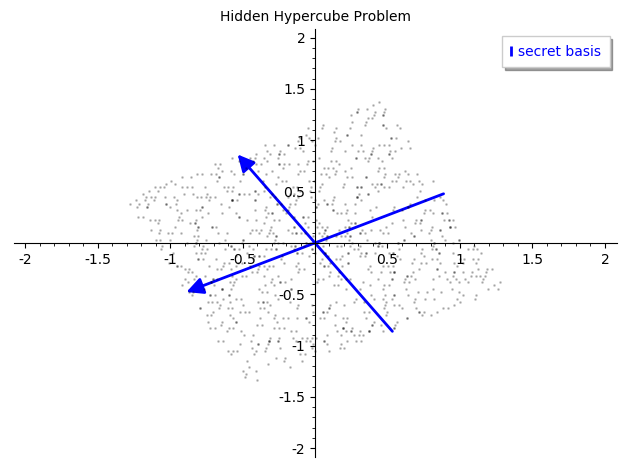

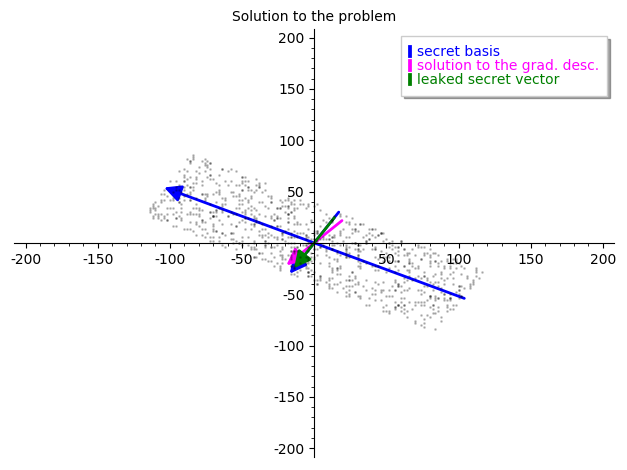

In [11]:
# plots
assert n == 2
a = l*2
scat = scatter_plot(samples, alpha=0.2, marker='o', markersize=1, facecolor='black', xmin=-a, xmax=a, ymin=-a, ymax=a, title = 'Hidden Parallelepiped Problem') +\
arrow(-vector(ggh.sk[0,:]),vector(ggh.sk[0,:]), color='blue') +\
arrow(-vector(ggh.sk[1,:]),vector(ggh.sk[1,:]), color='blue', legend_color='blue', legend_label="secret basis")
scat.show()

scat_hc = scatter_plot(samples_hypercube, alpha=0.2, marker='o', markersize=1, facecolor='black', xmin=-2, xmax=2, ymin=-2, ymax=2, title="Hidden Hypercube Problem") +\
arrow((-vector(ggh.sk[0,:])) * L, (vector(ggh.sk[0,:]))*L, color='blue') +\
arrow((-vector(ggh.sk[1,:])) * L, (vector(ggh.sk[1,:]))*L, color='blue', legend_color='blue', legend_label="secret basis")
scat_hc.show()
    
scat_hc = scatter_plot(samples, alpha=0.2, marker='o', markersize=1, facecolor='black', xmin=-a, xmax=a, ymin=-a, ymax=a, title="Solution to the problem") +\
arrow(-vector(ggh.sk[0,:]),vector(ggh.sk[0,:]), color='blue') +\
arrow(-vector(ggh.sk[1,:]),vector(ggh.sk[1,:]), color='blue', legend_color='blue', legend_label="secret basis") +\
arrow(-vector(v),vector(v), arrowshorten=10, color='magenta', legend_color='magenta', legend_label="solution to the grad. desc.") +\
arrow(-vector(sol),vector(sol), arrowshorten=10, color='green', legend_color='green', legend_label="leaked secret vector")
scat_hc.show()